In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
import glob
from PIL import Image
import torch.utils.data
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms.functional as Func
import timm
import cv2
import shutil
import zipfile

## Datasets Selection

### Training Set
   - **Description**: Contains 999 real ultrasound images.
   - **Measurements**: Includes already labeled masks.

### Test Set
   - **Description**: Contains 335 real ultrasound images.
   - **Measurements**: Masks were detected using a trained NestedUNET and manual adjustments using CV2 methods.

### GAN Set
   - **Description**: Contains 4689 fake ultrasound images.
   - **Measurements**: Masks were detected using a trained NestedUNET and manual adjustments using CV2 methods.

In [2]:
# Set flags True to include Test set and GAN set
include_test_set = True
include_gan_set = True

train_csv = pd.read_csv("/kaggle/input/fetalhcdata/training_set/training_set_circumference.csv")
train_csv['dataset'] = 'train'
train_img = "/kaggle/input/fetalhcdata/training_set/training_set"
train_mask = "/kaggle/input/fetalhcdata/training_set/images_mask"
print(f"Train samples: {len(train_csv)}")

if include_test_set:
    test_csv = pd.read_csv("/kaggle/input/fetalhcdata/test_set/test_set_circumference.csv")
    test_csv['dataset'] = 'test'
    test_img = "/kaggle/input/fetalhcdata/test_set/test_set"
    test_mask = "/kaggle/input/fetalhcdata/test_set/test_masks"
    print(f"Test samples: {len(test_csv)}")
    
if include_gan_set:
    gan_csv = pd.read_csv("/kaggle/input/fetalhcdata/gan_set/measured_circumference.csv")
    gan_csv['dataset'] = 'gan'
    gan_img = "/kaggle/input/fetalhcdata/gan_set/gan_images"
    gan_mask = "/kaggle/input/fetalhcdata/gan_set/gan_masks"
    print(f"GAN samples: {len(gan_csv)}")
    
dfs_to_concat = [train_csv]
if include_test_set:
    dfs_to_concat.append(test_csv)
if include_gan_set:
    dfs_to_concat.append(gan_csv)
    
merged_df = pd.concat(dfs_to_concat)

Train samples: 999
Test samples: 335
GAN samples: 4689


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
workers = 4 if torch.cuda.is_available() else 0
print(device)

cuda


## Data Preprocessing and Class Balancing
#### This code categorizes samples based on head circumference. It limits the number of samples per class based on `limit_per_class` to ensure balanced representation. The priority order is applied to select samples for removal in case of excess (highest priority starts from the right side). The resulting dataset, 'filtered_df', contains balanced samples across classes.

#### Also, the code cluster classes where we identified a small number of samples from training_set. For example, when classifying circumference, we have barely any samples in the first classes 4 and 5, so we set `lowest_value_cm` as 6 to combine them under class number 6.

#### Lastly, we have two optinal variables to adjust the sample distribution: `gan_samples_limit` allows to limit the number of GAN samples in each class, and `oversample_limit` upsamples all classes with fewer samples than the limit.

In [4]:
filtered_df = merged_df.copy()
lowest_value_cm, highest_value_cm, limit_per_class = 6, 33, 230
gan_samples_limit = 1000

# Calculate class based on the scale factor
filtered_df['class'] = np.round(filtered_df['Head_Circumference_cm'])

# Generate the classes list
classes = list(range(lowest_value_cm, highest_value_cm + 1))

# Priority order
priority = ['gan_new', 'gan', 'test', 'train']

filtered_df.loc[(filtered_df['class'] <= lowest_value_cm), 'class'] = lowest_value_cm
filtered_df.loc[(filtered_df['class'] > highest_value_cm), 'class'] = highest_value_cm

# Extract 20% of samples from all datasets and 20% from 'train' dataset
extracted_samples_test = []
extracted_samples_train = []
extracted_samples_gan = []
for cir_class in classes:
    samples_in_class = filtered_df[filtered_df['class'] == cir_class]
    sample_count_gan = len(samples_in_class[samples_in_class['dataset'] == 'gan'])
    sample_count_train = len(samples_in_class[samples_in_class['dataset'] == 'train'])
    sample_count_test = len(samples_in_class[samples_in_class['dataset'] == 'test'])
    
    if sample_count_train > 1:
        extract_count_train = max(1, int(sample_count_train * 0.2))
        extracted_samples_train.append(samples_in_class[samples_in_class['dataset'] == 'train'].sample(n=extract_count_train, random_state=42))
        
    if sample_count_gan > 1:
        extract_count_gan = max(1, int(sample_count_gan * 0.2)) 
        extracted_samples_gan.append(samples_in_class[samples_in_class['dataset'] == 'gan'].sample(n=extract_count_gan, random_state=42))
        
    if sample_count_test > 1:
        extract_count_test = max(1, int(sample_count_test * 0.2))
        extracted_samples_test.append(samples_in_class[samples_in_class['dataset'] == 'test'].sample(n=extract_count_test, random_state=42))

# Combine the extracted samples into a single DataFrame
extracted_samples = extracted_samples_test + extracted_samples_train + extracted_samples_gan
if extracted_samples:
    extracted_df = pd.concat(extracted_samples)
    # Remove the extracted samples from the merged_df
    indices_to_keep = ~filtered_df.set_index(['dataset', 'filename']).index.isin(extracted_df.set_index(['dataset', 'filename']).index)
    filtered_df = filtered_df.loc[indices_to_keep]
else:
    extracted_df = pd.DataFrame()
    
# Iterate over each class and limit the number of samples
for cir_class in classes:
    samples_in_class = filtered_df[filtered_df['class'] == cir_class]
    gan_samples_in_class = samples_in_class[(samples_in_class['dataset'] == 'gan')]
    
    if len(gan_samples_in_class) <= gan_samples_limit:
        continue
    
    samples_to_remove = len(gan_samples_in_class) - gan_samples_limit
    excess_samples = gan_samples_in_class.sample(n=samples_to_remove, random_state=42)
    indices_to_keep = ~filtered_df.set_index(['dataset', 'filename']).index.isin(excess_samples.set_index(['dataset', 'filename']).index)
    filtered_df = filtered_df.loc[indices_to_keep]

# Iterate over each class and limit the number of samples
for cir_class in classes:
    samples_in_class = filtered_df[filtered_df['class'] == cir_class]
    
    if (len(samples_in_class) == 0):
        print(f"Class {cir_class - lowest_value_cm} has no samples")

    if len(samples_in_class) <= limit_per_class:
        continue

    excess_count = len(samples_in_class) - limit_per_class
    
    for dataset in priority:
        if excess_count <= 0:
            break
        dataset_samples = samples_in_class[(samples_in_class['dataset'] == dataset)]
        if len(dataset_samples) > 0:
            samples_to_remove = min(len(dataset_samples), excess_count)
            excess_samples = dataset_samples.sample(n=samples_to_remove, random_state=42)
            indices_to_keep = ~filtered_df.set_index(['dataset', 'filename']).index.isin(excess_samples.set_index(['dataset', 'filename']).index)
            filtered_df = filtered_df.loc[indices_to_keep]
            excess_count -= samples_to_remove

# Create a new filtered_df with the filtered data
val_df = pd.concat(extracted_samples_train)
val_df = val_df.drop(columns=['class'])

filtered_df = filtered_df.drop(columns=['class'])

## Data Classification (for data visualization)
#### The `classify_head_measurements` function categorizes measurements into classes by rounding the cm measurements and normalizing them to start from 0. It returns the number of unique classes and a mapping of original class labels to normalized ones.

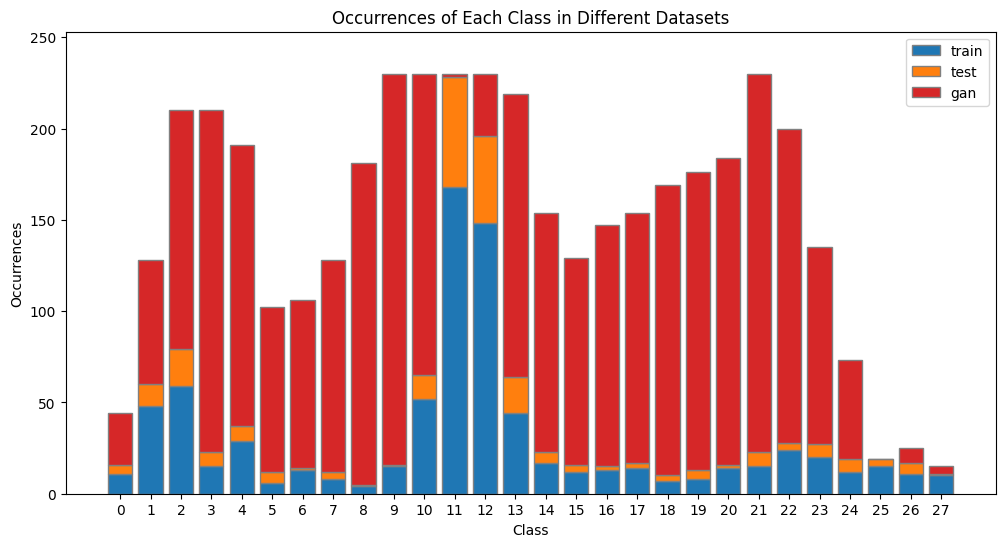

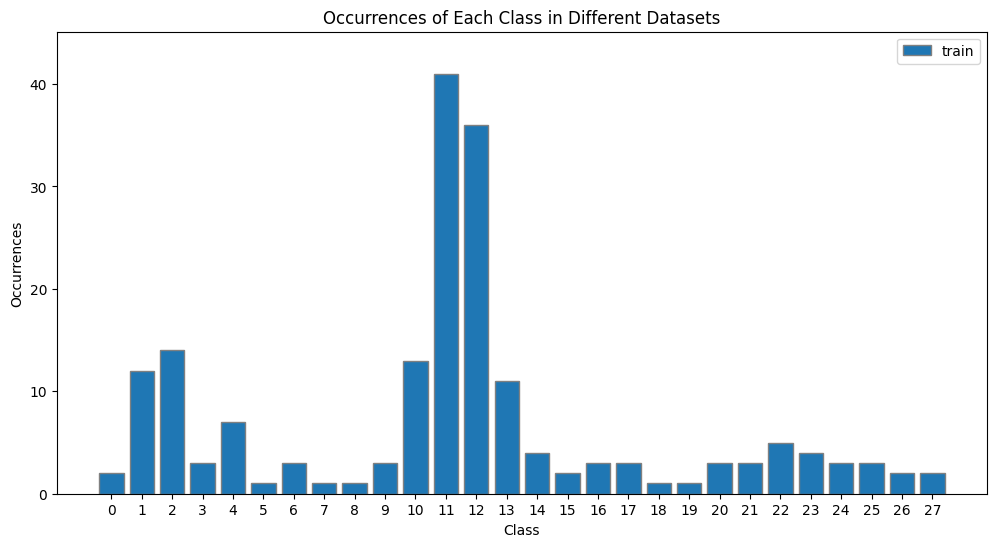

In [5]:
def classify_head_measurements(df):
    def round_classification(value):
        rounded_value = int(np.round(value))
        if rounded_value <= lowest_value_cm:
            return lowest_value_cm
        elif rounded_value > highest_value_cm:
            return highest_value_cm
        else:
            return rounded_value

    df['classes'] = df['Head_Circumference_cm'].apply(round_classification)
    
    # Normalize class labels to start from 0
    unique_classes = sorted(df['classes'].unique())
    class_mapping = {old_class: new_class for new_class, old_class in enumerate(unique_classes)}
    df['classes'] = df['classes'].map(class_mapping)
    
    num_classes = df['classes'].nunique()

    return num_classes, class_mapping

num_classes, class_mapping = classify_head_measurements(filtered_df)
classify_head_measurements(val_df)

def plot_class_distribution(df, dataset_colors=None):
    # Make a copy of the DataFrame to avoid altering the original
    df_copy = df.copy()
    
    # Identify unique datasets in the 'dataset' column
    unique_datasets = df_copy['dataset'].unique()

    # Initialize a dictionary to hold class counts for each dataset
    class_counts_dict = {}

    # Loop through each unique dataset and count class occurrences
    for dataset in unique_datasets:
        dataset_data = df_copy[df_copy['dataset'] == dataset]
        class_counts = dataset_data['classes'].value_counts().sort_index()
        class_counts_dict[dataset] = class_counts

    # Combine the counts into a single DataFrame
    class_counts = pd.DataFrame(class_counts_dict).fillna(0)

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))

    # Default colors if dataset_colors is not provided
    default_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    if dataset_colors is None:
        dataset_colors = {}
    
    # Bar width
    bar_width = 0.35

    # Initialize bottom for stacked bars
    bottom = None

    for i, dataset in enumerate(class_counts.columns):
        if bottom is None:
            bottom = np.zeros_like(class_counts[dataset])

        # Get color for current dataset
        color = dataset_colors.get(dataset, default_colors[i % len(default_colors)])

        ax.bar(class_counts.index, class_counts[dataset], bottom=bottom, color=color, edgecolor='grey', label=dataset)
        bottom += class_counts[dataset]

    # Add labels
    ax.set_xlabel('Class')
    ax.set_ylabel('Occurrences')
    ax.set_title('Occurrences of Each Class in Different Datasets')
    ax.legend()

    # Set x-axis tick labels with class numbers
    ax.set_xticks(range(len(class_counts)))
    ax.set_xticklabels(class_counts.index)

    # Increase y-axis limit a little more than the top value
    max_count = class_counts.sum(axis=1).max()
    ax.set_ylim(0, max_count * 1.1)

    # Show plot
    plt.show()

dataset_colors = {'train': '#1f77b4', 'test': '#ff7f0e', 'gan': '#d62728', 'gan_new': '#9467bd'}
plot_class_distribution(filtered_df, dataset_colors)
plot_class_distribution(val_df, dataset_colors)

## Initialize NUDataset Class

In [6]:
class NUDataset(torch.utils.data.Dataset):
  def __init__(self, df, img_paths, mask_paths, transform_X=None,transform_Y = None):
    self.X = [
            os.path.join(img_paths[dataset], filename) 
            for filename, dataset in zip(df['filename'], df['dataset'])
        ]
    self.Y = [
            os.path.join(mask_paths[dataset], mask_filename) 
            for mask_filename, dataset in zip(df['mask_filename'], df['dataset'])
        ]
    self.dataset = df['dataset'].tolist()
    self.transform_X = transform_X
    self.transform_Y = transform_Y

  def __len__(self):
      return len(self.X)

  def __getitem__(self,idx):
    X_path = self.X[idx]
    Y_path = self.Y[idx]

    X = Image.open(X_path).convert("L")
    Y = Image.open(Y_path).convert("L")

    if self.transform_X is not None:
        X = self.transform_X(X)

    if self.transform_Y is not None:
        Y = self.transform_Y(Y)
        
    # Extract dataset type
    Dataset_type = self.dataset[idx]

    return X, Y, Dataset_type

In [7]:
img_size = 512

transform_X = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_Y = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])

img_paths = {
    'train': train_img
}

mask_paths = {
    'train': train_mask
}

if include_test_set:
    img_paths['test'] = test_img
    mask_paths['test'] = test_mask
    
if include_gan_set:
    img_paths['gan'] = gan_img
    mask_paths['gan'] = gan_mask

unet_dataset = NUDataset(filtered_df, img_paths, mask_paths, transform_X, transform_Y)
unet_val = NUDataset(val_df, img_paths, mask_paths, transform_X, transform_Y)

## Testing Class Output

In [8]:
print(len(unet_dataset))
print(len(unet_val))

4249
187


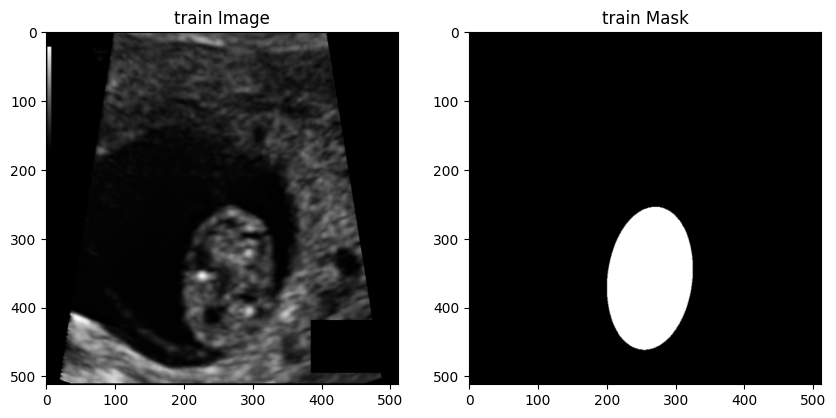

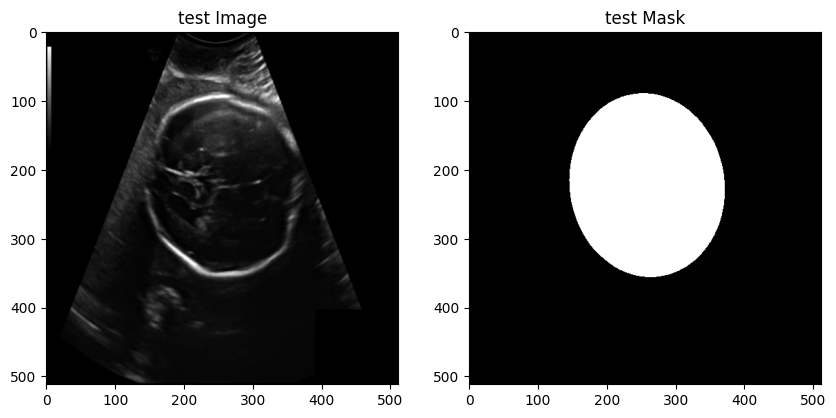

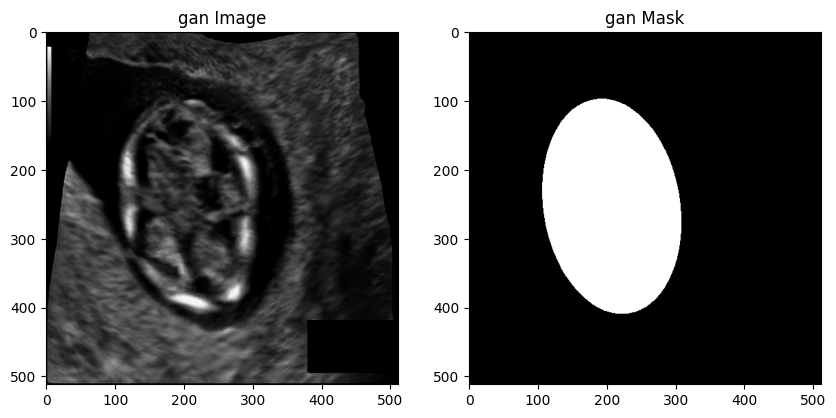

In [9]:
# Function to plot a single sample
def plot_sample(dataset, idx):
    X, Y, D = dataset[idx]
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(X.squeeze(), cmap='gray')
    ax[0].set_title(f'{D} Image')
    ax[1].imshow(Y.squeeze(), cmap='gray')
    ax[1].set_title(f'{D} Mask')
    plt.show()

# Plot a sample from the training set
train_sample_idx = 0
plot_sample(unet_dataset, train_sample_idx)

if include_test_set:
    # Plot a sample from the testing set
    test_sample_idx = len(train_csv)
    plot_sample(unet_dataset, test_sample_idx)
    
if include_gan_set:
    # Plot a sample from the GAN set
    gan_sample_idx = len(train_csv) + len(test_csv)
    plot_sample(unet_dataset, gan_sample_idx)

## Declare NestedUNet Class 

In [10]:
class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class NestedUNet(nn.Module):
    def __init__(self, n_channels, n_classes, deep_supervision=False):
        super(NestedUNet, self).__init__()
        self.deep_supervision = deep_supervision
        nb_filter = [32, 64, 128, 256, 512]

        self.conv0_0 = double_conv(n_channels, nb_filter[0])
        self.conv1_0 = double_conv(nb_filter[0], nb_filter[1])
        self.conv2_0 = double_conv(nb_filter[1], nb_filter[2])
        self.conv3_0 = double_conv(nb_filter[2], nb_filter[3])
        self.conv4_0 = double_conv(nb_filter[3], nb_filter[4])

        self.conv0_1 = double_conv(nb_filter[0]+nb_filter[1], nb_filter[0])
        self.conv1_1 = double_conv(nb_filter[1]+nb_filter[2], nb_filter[1])
        self.conv2_1 = double_conv(nb_filter[2]+nb_filter[3], nb_filter[2])
        self.conv3_1 = double_conv(nb_filter[3]+nb_filter[4], nb_filter[3])

        self.conv0_2 = double_conv(nb_filter[0]*2+nb_filter[1], nb_filter[0])
        self.conv1_2 = double_conv(nb_filter[1]*2+nb_filter[2], nb_filter[1])
        self.conv2_2 = double_conv(nb_filter[2]*2+nb_filter[3], nb_filter[2])

        self.conv0_3 = double_conv(nb_filter[0]*3+nb_filter[1], nb_filter[0])
        self.conv1_3 = double_conv(nb_filter[1]*3+nb_filter[2], nb_filter[1])

        self.conv0_4 = double_conv(nb_filter[0]*4+nb_filter[1], nb_filter[0])

        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        if self.deep_supervision:
            self.final1 = nn.Conv2d(nb_filter[0], n_classes, kernel_size=1)
            self.final2 = nn.Conv2d(nb_filter[0], n_classes, kernel_size=1)
            self.final3 = nn.Conv2d(nb_filter[0], n_classes, kernel_size=1)
            self.final4 = nn.Conv2d(nb_filter[0], n_classes, kernel_size=1)
        else:
            self.final = nn.Conv2d(nb_filter[0], n_classes, kernel_size=1)

        self.sigmoid = nn.Sigmoid()  # Sigmoid activation

    def forward(self, x):
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(F.max_pool2d(x0_0, 2))
        x2_0 = self.conv2_0(F.max_pool2d(x1_0, 2))
        x3_0 = self.conv3_0(F.max_pool2d(x2_0, 2))
        x4_0 = self.conv4_0(F.max_pool2d(x3_0, 2))

        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))

        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))

        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))

        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        if self.deep_supervision:
            output1 = self.sigmoid(self.final1(x0_1))
            output2 = self.sigmoid(self.final2(x0_2))
            output3 = self.sigmoid(self.final3(x0_3))
            output4 = self.sigmoid(self.final4(x0_4))
            return [output1, output2, output3, output4]

        else:
            output = self.sigmoid(self.final(x0_4))
            return output

## Declare dice loss methods

In [11]:
def dice_coeff(y_pred, y_targets):
    smooth = 1
    num = y_targets.size(0)
    m1 = y_pred.view(num, -1)
    m2 = y_targets.view(num, -1)
    intersection = (m1 * m2)

    score = 2. * (intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
    score = score.sum() / num
    return score.item()


def dice_loss(y_predict, y_train):
    
    dice_loss = 1 -(dice_coeff(y_predict, y_train))
    return dice_loss

## Dividing Data for Cross Validation

In [12]:
# Define batch size
batch_size = 5

# Create data loaders
train_loader = DataLoader(unet_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
val_loader = DataLoader(unet_val, batch_size=batch_size, num_workers=workers)

## Training the model

In [13]:
from torch.optim.lr_scheduler import CosineAnnealingLR

def train_and_validate(model, train_loader, validation_loader, criterion, optimizer, epochs=5, train_loss_threshold=None):
    train_running_loss_history = []
    validation_running_loss_history = []
    lr_history = []
    prev_val_loss = float('inf')
    early_stop = False
    
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

    for e in range(epochs):

        train_running_loss = 0.0
        validation_running_loss = 0.0
        
        if early_stop:
            break

        model.train()
        # Training loop
        for ith_batch, sample_batched in enumerate(train_loader):
            x_train, y_train, _ = sample_batched
            X_train = x_train.to(device)
            Y_train= y_train.to(device)

            optimizer.zero_grad()
            y_pred = model(X_train)

            # Calculate losses
            loss = 0.3 * dice_loss(y_pred, Y_train) + 0.7 * criterion(y_pred, Y_train)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            train_running_loss += loss.item()
        
        
        scheduler.step()
        lr_history.append(optimizer.param_groups[0]['lr'])

        # Validation loop
        with torch.no_grad():
            model.eval()
            for ith_batch, sample_batched in enumerate(validation_loader):
                x_val, y_val, _ = sample_batched
                X_val = x_val.to(device)
                Y_val= y_val.to(device)

                pred_val = model(X_val)
                
                # Calculate losses
                out_val = (pred_val + 0.5).int().float()
                val_loss = 0.3 * dice_loss(out_val, Y_val) + 0.7 * criterion(pred_val, Y_val)
                
                validation_running_loss += val_loss.item()

            train_epoch_loss = train_running_loss / len(train_loader)
            validation_epoch_loss = validation_running_loss / len(validation_loader)

            train_running_loss_history.append(train_epoch_loss)
            validation_running_loss_history.append(validation_epoch_loss)
            
            print("================================================================================")
            print(f"Epoch {e + 1} completed")
            print(f"Average train loss: {train_epoch_loss}")
            print(f"Average validation loss: {validation_epoch_loss}")
            print("================================================================================")
            
            if train_loss_threshold is not None:
                if train_epoch_loss < train_loss_threshold and validation_epoch_loss >= prev_val_loss:
                    print("Stopping training as training loss is below threshold and validation loss has stopped decreasing.")
                    early_stop = True
                prev_val_loss = validation_epoch_loss

        torch.cuda.empty_cache()

    # Plot loss history
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(train_running_loss_history, label='Train Loss')
    plt.plot(validation_running_loss_history, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot learning rate
    plt.subplot(1, 2, 2)
    plt.plot(lr_history, label='Learning Rate')
    plt.xlabel('Step')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.legend()

    plt.tight_layout()
    plt.show()

Epoch 1 completed
Average train loss: 0.14537023700773716
Average validation loss: 0.09047409313681878
Epoch 2 completed
Average train loss: 0.05966311576611855
Average validation loss: 0.07285583646673906
Epoch 3 completed
Average train loss: 0.04650865521281958
Average validation loss: 0.06210263186183415
Epoch 4 completed
Average train loss: 0.041842089025851556
Average validation loss: 0.061029840260744095
Epoch 5 completed
Average train loss: 0.03616705483373474
Average validation loss: 0.06374235941391242
Epoch 6 completed
Average train loss: 0.034593321602134144
Average validation loss: 0.05958282462272205
Epoch 7 completed
Average train loss: 0.03140743650167304
Average validation loss: 0.04920766536930674
Epoch 8 completed
Average train loss: 0.028477716632187365
Average validation loss: 0.045778137827782256
Epoch 9 completed
Average train loss: 0.026661498778883148
Average validation loss: 0.04617317128730448
Epoch 10 completed
Average train loss: 0.02532606319688699
Average 

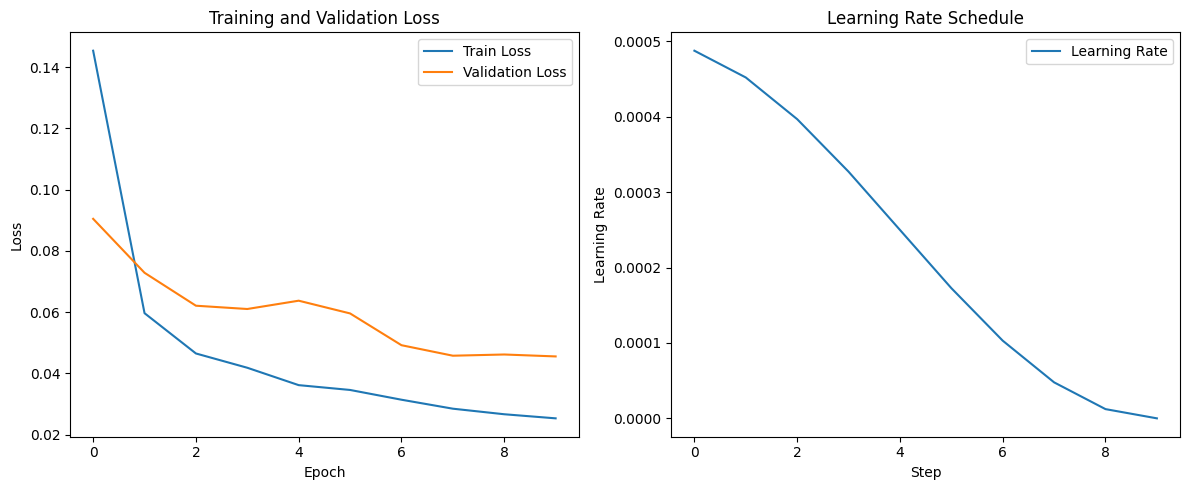

In [14]:
epochs = 10
learning_rate = 0.0005
weight_decay = 0.01

criterion = nn.BCELoss()

model = NestedUNet(n_channels=1, n_classes=1)

# Use DataParallel for multi-GPU training
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs, 0.015)

## Evaluation

In [15]:
def mean_absolute_difference(pred, target):
    return torch.mean(torch.abs(pred - target))

def evaluate_model(dataloader):
    total_dice = 0.0
    total_mad = 0.0
    model.eval()
    
    with torch.no_grad():
        for ith_batch, sample_batched in enumerate(dataloader):
            X_train, y_train, _ = sample_batched
            X_train, y_train = X_train.to(device), y_train.to(device)

            y_predict_probs = model(X_train)
            y_predict = (y_predict_probs > 0.5).float()

            total_dice += dice_coeff(y_predict, y_train)
            total_mad += mean_absolute_difference(y_predict, y_train)

    avg_dice = total_dice / len(dataloader)
    avg_mad = total_mad / len(dataloader)
    return avg_dice, avg_mad

avg_dice_res, avg_mad_res = evaluate_model(val_loader)
print(f'Average Dice Coefficient: {avg_dice_res}')
print(f'Average Mean Absolute Difference: {avg_mad_res}')

Average Dice Coefficient: 0.9635833737097288
Average Mean Absolute Difference: 0.01836554706096649


In [16]:
def test_ellipse(imgray):
    ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None
    largest_contour = max(contours, key=cv2.contourArea)
    if len(largest_contour) < 5:
        return None
    ellipse = cv2.fitEllipse(largest_contour)
    return ellipse

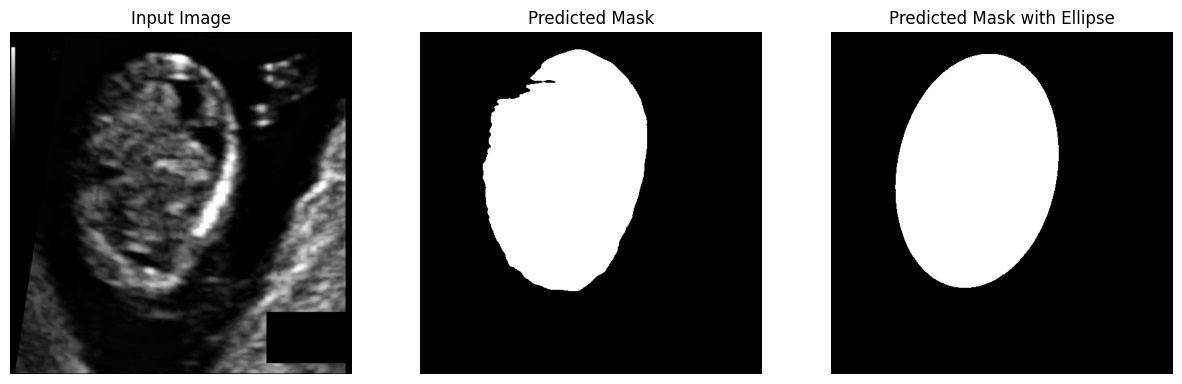

In [17]:
# Load an example from the dataset
x, y, _ = unet_val[0]

# Convert the tensor to a NumPy array
img_x = x.numpy().reshape(img_size, img_size)

# Prepare the input tensor and make a prediction
x = x.unsqueeze(0).to(device)
with torch.no_grad():
    model.eval()
    pred_mask = model(x)
    pred_mask = (pred_mask > 0.5).float().cpu().squeeze().numpy().reshape(img_size, img_size)

# Convert the predicted mask to a 3-channel image for OpenCV
img_pred_color = cv2.cvtColor((pred_mask * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)

# Apply the ellipse fitting function
ellipse = test_ellipse((pred_mask * 255).astype(np.uint8))
im_mask = cv2.ellipse(np.zeros_like((pred_mask * 255).astype(np.uint8)), ellipse, (255, 255, 255), -1)

# Display images
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Input Image')
plt.imshow(img_x, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Predicted Mask')
plt.imshow(pred_mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Predicted Mask with Ellipse')
plt.imshow(cv2.cvtColor(im_mask, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

In [19]:
model_path = "segmentation_model.pth"
torch.save(model.module.state_dict(), model_path)